# BigP3BCI Exploration
This notebook provides an overview of the dataset and basic filtering.

Detect dataset location and ensure the first EDF file is available.

In [1]:

from pathlib import Path
import os

base = Path(os.environ.get('NEURO_DATA_ROOT', Path.cwd() / 'data'))
rel = Path('bigP3BCI-data/StudyA/A_01/SE001/Train/CB/A_01_SE001_CB_Train01.edf')
raw_path = base / rel
if not raw_path.exists():
    alt = base / 'bigp3bci-an-open-diverse-and-machine-learning-ready-p300-based-brain-computer-interface-dataset-1.0.0' / rel
    raw_path = alt
if not raw_path.exists():
    raise FileNotFoundError('Please run `dvc pull` to fetch the dataset')
root = raw_path.parents[5]

## 1. Dataset structure
Print directory tree and EDF counts per session.

In [2]:

from neurohub.io import list_dataset_structure
import pandas as pd

df = list_dataset_structure(root)
print('Total files:', len(df))
counts = df.groupby(['study','subject','session']).size().rename('n_files').reset_index()
counts


Total files: 10


,study,subject,session,n_files
0,StudyA,A_01,SE001,10


## 2. Channel metadata
Table with channel name, type and original filter settings.

In [3]:

from neurohub.io import load_bigp3bci
import mne

raw = load_bigp3bci(raw_path)
ch_types = [mne.channel_type(raw.info, idx) for idx in range(len(raw.ch_names))]
meta = pd.DataFrame({'name': raw.ch_names, 'type': ch_types})
meta['highpass'] = raw.info['highpass']
meta['lowpass'] = raw.info['lowpass']
meta.head()


/workspace/neuroHub/neurohub/io.py:69: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  return mne.io.read_raw_edf(path, preload=True, verbose=False)
/workspace/neuroHub/neurohub/io.py:69: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  return mne.io.read_raw_edf(path, preload=True, verbose=False)


,name,type,highpass,lowpass
0,EEG_F3,eeg,58.0,62.0
1,EEG_Fz,eeg,58.0,62.0
2,EEG_F4,eeg,58.0,62.0
3,EEG_T7,eeg,58.0,62.0
4,EEG_C3,eeg,58.0,62.0


## 3. Event overview
Distribution of target vs non-target and inter-flash intervals.

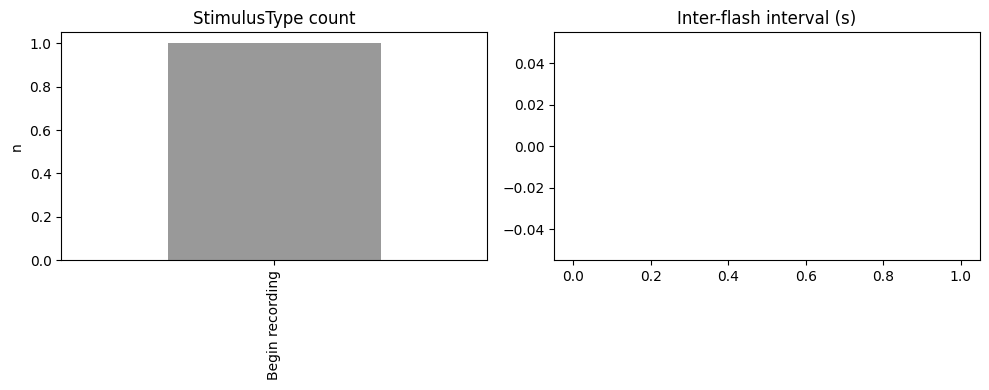

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# Смотрим статистику событий: таргет / нетаргет
anns = raw.annotations
ev_types = anns.description
onsets = anns.onset
intervals = np.diff(onsets)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
(pd.Series(ev_types).value_counts().plot.bar(ax=axes[0], color='0.6'))
axes[0].set_title('StimulusType count')
axes[0].set_ylabel('n')
axes[1].hist(intervals, bins=20, color='0.6')
axes[1].set_title('Inter-flash interval (s)')
fig.tight_layout()


## 4. Band-pass filter demo
Apply 0.1--30 Hz filter and show frequency response.

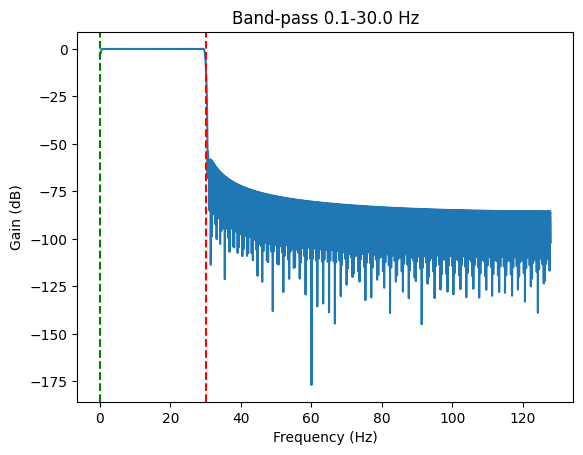

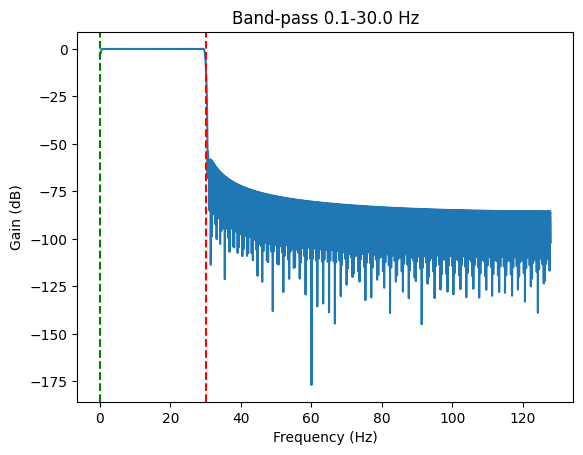

In [5]:

from neurohub.preproc import apply_bandpass, plot_filter_response

fig = plot_filter_response(0.1, 30.0, raw.info['sfreq'])
fig


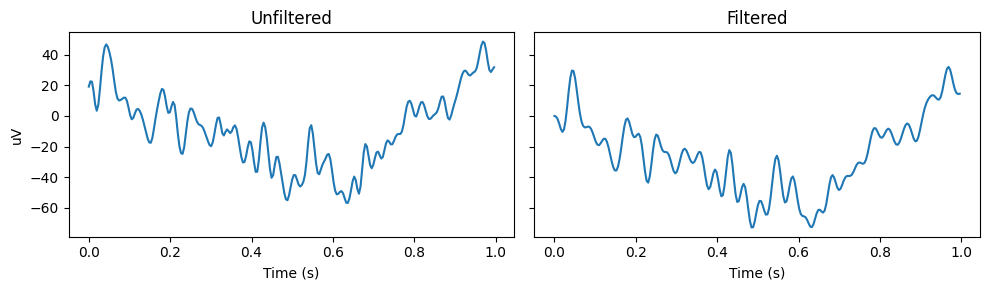

In [6]:

# Демонстрируем фильтр 0.1-30 Гц и его влияние на сигнал
raw_filt = raw.copy()
apply_bandpass(raw_filt)

ch = 'Cz' if 'Cz' in raw.ch_names else raw.ch_names[0]
idx = raw.ch_names.index(ch)

sig = raw.get_data(picks=[idx])[0]
fsig = raw_filt.get_data(picks=[idx])[0]
t = raw.times

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)
axes[0].plot(t[:int(raw.info['sfreq'])], sig[:int(raw.info['sfreq'])]*1e6)
axes[0].set_title('Unfiltered')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('uV')
axes[1].plot(t[:int(raw.info['sfreq'])], fsig[:int(raw.info['sfreq'])]*1e6)
axes[1].set_title('Filtered')
axes[1].set_xlabel('Time (s)')
fig.tight_layout()


## 5. Power spectrum
Average PSD up to 40 Hz and mark channels with zero/inf power.

Effective window size : 8.000 (s)


/tmp/ipykernel_12737/942582324.py:1: UserWarning: Zero value in spectrum for channels FakeFeedback, DisplayResults
  psd = raw_filt.compute_psd(fmax=40)


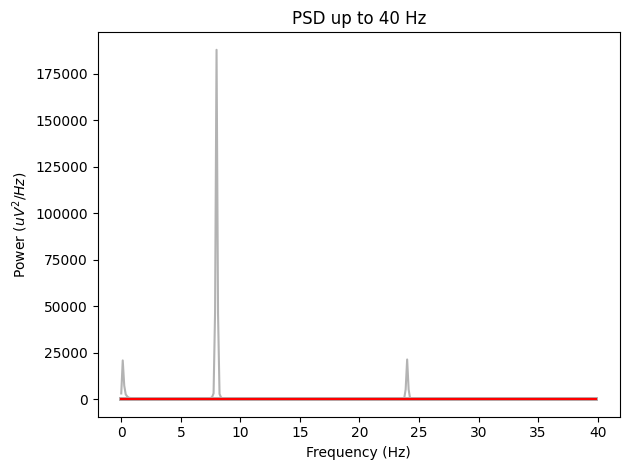

In [7]:

psd = raw_filt.compute_psd(fmax=40)
avg = psd.get_data().mean(axis=1)
bad = ~np.isfinite(avg) | (avg == 0)
fig, ax = plt.subplots()
ax.plot(psd.freqs, psd.get_data().T, color='0.7')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power ($uV^2/Hz$)')
ax.set_title('PSD up to 40 Hz')
for i, b in enumerate(bad):
    if b:
        ax.plot(psd.freqs, psd.get_data()[i], color='r')
fig.tight_layout()


## Key takeaways
- BigP3BCI files are organised by study/subject/session.
- Channels store original filter hints in the header.
- Events allow computing flash statistics.
- Band-pass 0.1--30 Hz removes slow drift and high noise.